# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

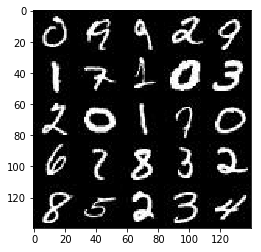

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

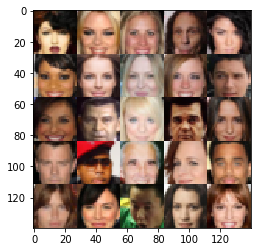

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01, training=False, keep_prob=0.7):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized convolutional layer 
    def conv2d_batch_normalized(input_, depth, kernel_size, stride_size, activation):
        conv = tf.layers.conv2d(input_, depth, kernel_size, strides=stride_size, padding='same', use_bias=False,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=training)
        conv = activation(conv)
        if training:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Apply some convolutions
        conv1 = conv2d_batch_normalized(images, 256, 3, 2, lrelu) 
        conv2 = conv2d_batch_normalized(conv1, 512, 3, 2, lrelu)
        conv3 = conv2d_batch_normalized(conv2, 1024, 3, 2, lrelu)
        
        shape = conv3.get_shape().as_list()
        
        # Reshape, get logits and sigmoid
        flattened = tf.reshape(conv3, [-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized transpose convolution
    def conv2d_trans_batch_normalized(input_, depth, kernel_size, stride_size, activation, padding='same'):
        conv = tf.layers.conv2d_transpose(input_, depth, kernel_size, strides=stride_size, padding=padding, use_bias=False,
                                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = activation(conv)
        if is_train:
            conv = tf.nn.dropout(conv, keep_prob)
        return conv
    
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # Get a deep layer from the random input
        x = tf.layers.dense(z, 1024*3*3, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, [-1, 3, 3, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x)
        if is_train:
            x = tf.nn.dropout(x, keep_prob=0.7)
        
        # Apply some transpose convolutions
        conv1 = conv2d_trans_batch_normalized(x, 512, 3, 2, lrelu) # 6x6x512
        conv2 = conv2d_trans_batch_normalized(conv1, 256, 4, 2, lrelu, 'valid') # 14x14x256
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 3, 2, padding='same', # 28x28x(out_channel_dim)
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)) 
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01, smooth=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    disc_fake_out, disc_fake_logits = discriminator(gen_out, reuse=True, alpha=alpha)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_real_logits)*(1-smooth),
        logits = disc_real_logits
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.zeros_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode,alpha=0.01):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha = 0.01, print_every=50, show_every=500, gen_samples=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, z_input, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, z_input, channels, alpha=alpha)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_n = 0           
            for batch_images in get_batches(batch_size):
                # Normalize images to be in the [-1, 1] range
                batch_images *= 2
                
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))            
                sess.run(disc_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                # Seen in slack: run generator twice to avoid the discriminator overpowering it
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                if batch_n % print_every == 0:
                    dloss = disc_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    gloss = gen_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    print("Epoch: {}, Batch: {}, Disc. Loss: {:4f}, Gen. Loss: {:4f}".format(epoch_i+1, batch_n, dloss, gloss))
                
                if batch_n % show_every == 0:
                    show_generator_output(sess, gen_samples, z_input, channels, data_image_mode, alpha=alpha)
                    
                batch_n += 1
            show_generator_output(sess, gen_samples, z_input, channels, data_image_mode)
    
    return sess 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1, Batch: 0, Disc. Loss: 1.225623, Gen. Loss: 0.624978


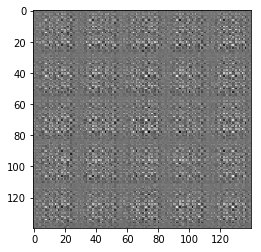

Epoch: 1, Batch: 50, Disc. Loss: 1.348338, Gen. Loss: 0.754137
Epoch: 1, Batch: 100, Disc. Loss: 1.332643, Gen. Loss: 0.710397
Epoch: 1, Batch: 150, Disc. Loss: 1.395809, Gen. Loss: 0.672804
Epoch: 1, Batch: 200, Disc. Loss: 1.668776, Gen. Loss: 0.616938
Epoch: 1, Batch: 250, Disc. Loss: 1.477030, Gen. Loss: 0.658058
Epoch: 1, Batch: 300, Disc. Loss: 1.394042, Gen. Loss: 0.757325
Epoch: 1, Batch: 350, Disc. Loss: 1.276421, Gen. Loss: 0.714620
Epoch: 1, Batch: 400, Disc. Loss: 1.438650, Gen. Loss: 0.613277
Epoch: 1, Batch: 450, Disc. Loss: 1.302122, Gen. Loss: 0.668902
Epoch: 1, Batch: 500, Disc. Loss: 1.547344, Gen. Loss: 0.663324


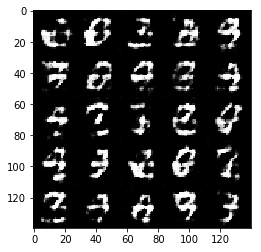

Epoch: 1, Batch: 550, Disc. Loss: 1.405080, Gen. Loss: 0.685331
Epoch: 1, Batch: 600, Disc. Loss: 1.232950, Gen. Loss: 0.804667
Epoch: 1, Batch: 650, Disc. Loss: 1.378445, Gen. Loss: 0.549532
Epoch: 1, Batch: 700, Disc. Loss: 1.429476, Gen. Loss: 0.649042
Epoch: 1, Batch: 750, Disc. Loss: 1.274037, Gen. Loss: 0.906077
Epoch: 1, Batch: 800, Disc. Loss: 1.277843, Gen. Loss: 0.705214
Epoch: 1, Batch: 850, Disc. Loss: 1.200761, Gen. Loss: 0.732825
Epoch: 1, Batch: 900, Disc. Loss: 1.291091, Gen. Loss: 0.667381
Epoch: 1, Batch: 950, Disc. Loss: 1.321873, Gen. Loss: 0.698634
Epoch: 1, Batch: 1000, Disc. Loss: 1.190214, Gen. Loss: 0.771917


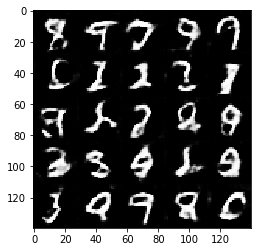

Epoch: 1, Batch: 1050, Disc. Loss: 1.362131, Gen. Loss: 0.871585
Epoch: 1, Batch: 1100, Disc. Loss: 1.159430, Gen. Loss: 1.007314
Epoch: 1, Batch: 1150, Disc. Loss: 1.337897, Gen. Loss: 0.574921
Epoch: 1, Batch: 1200, Disc. Loss: 1.157799, Gen. Loss: 0.733743
Epoch: 1, Batch: 1250, Disc. Loss: 1.151472, Gen. Loss: 0.815997
Epoch: 1, Batch: 1300, Disc. Loss: 1.164400, Gen. Loss: 0.951871
Epoch: 1, Batch: 1350, Disc. Loss: 1.214010, Gen. Loss: 0.921799
Epoch: 1, Batch: 1400, Disc. Loss: 1.072449, Gen. Loss: 1.045917
Epoch: 1, Batch: 1450, Disc. Loss: 1.138743, Gen. Loss: 1.039377
Epoch: 1, Batch: 1500, Disc. Loss: 0.996092, Gen. Loss: 0.914084


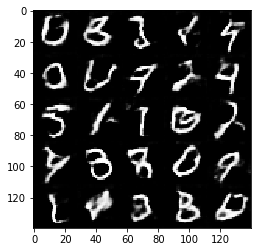

Epoch: 1, Batch: 1550, Disc. Loss: 1.135833, Gen. Loss: 0.792847
Epoch: 1, Batch: 1600, Disc. Loss: 0.944443, Gen. Loss: 1.086238
Epoch: 1, Batch: 1650, Disc. Loss: 1.123863, Gen. Loss: 0.638222
Epoch: 1, Batch: 1700, Disc. Loss: 0.872656, Gen. Loss: 1.175301
Epoch: 1, Batch: 1750, Disc. Loss: 0.830544, Gen. Loss: 1.290124
Epoch: 1, Batch: 1800, Disc. Loss: 1.097843, Gen. Loss: 1.903959
Epoch: 1, Batch: 1850, Disc. Loss: 0.890617, Gen. Loss: 1.330995


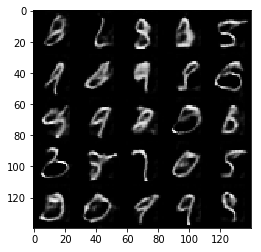

Epoch: 2, Batch: 0, Disc. Loss: 1.042438, Gen. Loss: 0.779209


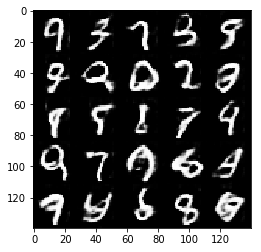

Epoch: 2, Batch: 50, Disc. Loss: 1.085920, Gen. Loss: 0.741356
Epoch: 2, Batch: 100, Disc. Loss: 1.019274, Gen. Loss: 1.032643
Epoch: 2, Batch: 150, Disc. Loss: 0.865091, Gen. Loss: 1.568092
Epoch: 2, Batch: 200, Disc. Loss: 0.951738, Gen. Loss: 1.278804
Epoch: 2, Batch: 250, Disc. Loss: 0.914623, Gen. Loss: 1.754456
Epoch: 2, Batch: 300, Disc. Loss: 0.942237, Gen. Loss: 0.988818
Epoch: 2, Batch: 350, Disc. Loss: 0.641643, Gen. Loss: 1.354304
Epoch: 2, Batch: 400, Disc. Loss: 0.780227, Gen. Loss: 1.601825
Epoch: 2, Batch: 450, Disc. Loss: 0.792465, Gen. Loss: 1.240326
Epoch: 2, Batch: 500, Disc. Loss: 0.659415, Gen. Loss: 1.230076


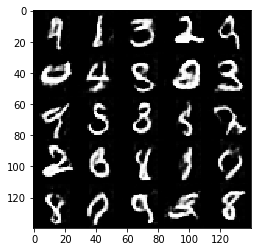

Epoch: 2, Batch: 550, Disc. Loss: 1.347573, Gen. Loss: 0.490720
Epoch: 2, Batch: 600, Disc. Loss: 0.966525, Gen. Loss: 1.074560
Epoch: 2, Batch: 650, Disc. Loss: 0.804520, Gen. Loss: 0.848091
Epoch: 2, Batch: 700, Disc. Loss: 0.763610, Gen. Loss: 1.478346
Epoch: 2, Batch: 750, Disc. Loss: 0.830622, Gen. Loss: 1.160280
Epoch: 2, Batch: 800, Disc. Loss: 0.721915, Gen. Loss: 1.760656
Epoch: 2, Batch: 850, Disc. Loss: 0.790943, Gen. Loss: 1.144218
Epoch: 2, Batch: 900, Disc. Loss: 0.601965, Gen. Loss: 1.688436
Epoch: 2, Batch: 950, Disc. Loss: 0.827195, Gen. Loss: 1.069556
Epoch: 2, Batch: 1000, Disc. Loss: 0.703514, Gen. Loss: 1.266105


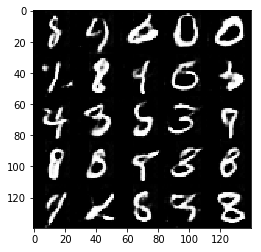

Epoch: 2, Batch: 1050, Disc. Loss: 1.078485, Gen. Loss: 0.581640
Epoch: 2, Batch: 1100, Disc. Loss: 0.821760, Gen. Loss: 2.347184
Epoch: 2, Batch: 1150, Disc. Loss: 0.645042, Gen. Loss: 1.301978
Epoch: 2, Batch: 1200, Disc. Loss: 0.848122, Gen. Loss: 2.588471
Epoch: 2, Batch: 1250, Disc. Loss: 0.775405, Gen. Loss: 1.026093
Epoch: 2, Batch: 1300, Disc. Loss: 0.625828, Gen. Loss: 1.698031
Epoch: 2, Batch: 1350, Disc. Loss: 0.613481, Gen. Loss: 2.026033
Epoch: 2, Batch: 1400, Disc. Loss: 0.512351, Gen. Loss: 2.213646
Epoch: 2, Batch: 1450, Disc. Loss: 0.787901, Gen. Loss: 2.146857
Epoch: 2, Batch: 1500, Disc. Loss: 0.562340, Gen. Loss: 1.726271


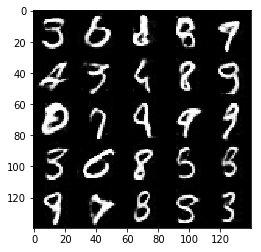

Epoch: 2, Batch: 1550, Disc. Loss: 0.964371, Gen. Loss: 3.220652
Epoch: 2, Batch: 1600, Disc. Loss: 0.534184, Gen. Loss: 2.159278
Epoch: 2, Batch: 1650, Disc. Loss: 0.661345, Gen. Loss: 2.184591
Epoch: 2, Batch: 1700, Disc. Loss: 0.612710, Gen. Loss: 1.777958
Epoch: 2, Batch: 1750, Disc. Loss: 0.485185, Gen. Loss: 2.178005
Epoch: 2, Batch: 1800, Disc. Loss: 0.639269, Gen. Loss: 1.594473
Epoch: 2, Batch: 1850, Disc. Loss: 0.902418, Gen. Loss: 2.920587


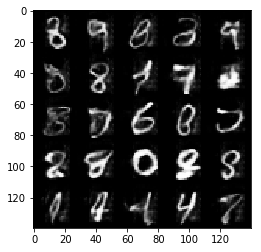

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    mnist_sess = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
                       mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1, Batch: 0, Disc. Loss: 1.307113, Gen. Loss: 0.608064


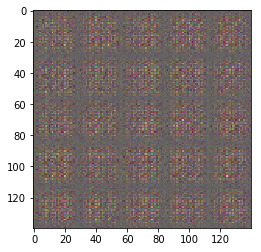

Epoch: 1, Batch: 50, Disc. Loss: 1.368161, Gen. Loss: 0.581880
Epoch: 1, Batch: 100, Disc. Loss: 1.498400, Gen. Loss: 0.475606
Epoch: 1, Batch: 150, Disc. Loss: 1.274290, Gen. Loss: 0.695202
Epoch: 1, Batch: 200, Disc. Loss: 1.495503, Gen. Loss: 0.710787
Epoch: 1, Batch: 250, Disc. Loss: 1.318436, Gen. Loss: 0.725732
Epoch: 1, Batch: 300, Disc. Loss: 1.148978, Gen. Loss: 0.717231
Epoch: 1, Batch: 350, Disc. Loss: 1.410191, Gen. Loss: 0.677225
Epoch: 1, Batch: 400, Disc. Loss: 1.378075, Gen. Loss: 0.878259
Epoch: 1, Batch: 450, Disc. Loss: 1.370629, Gen. Loss: 0.711079
Epoch: 1, Batch: 500, Disc. Loss: 1.280947, Gen. Loss: 0.709472


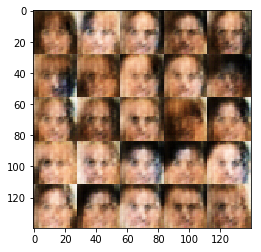

Epoch: 1, Batch: 550, Disc. Loss: 1.345646, Gen. Loss: 0.703526
Epoch: 1, Batch: 600, Disc. Loss: 1.272584, Gen. Loss: 0.713337
Epoch: 1, Batch: 650, Disc. Loss: 1.395429, Gen. Loss: 0.624752
Epoch: 1, Batch: 700, Disc. Loss: 1.417148, Gen. Loss: 0.814210
Epoch: 1, Batch: 750, Disc. Loss: 1.286224, Gen. Loss: 0.811847
Epoch: 1, Batch: 800, Disc. Loss: 1.234349, Gen. Loss: 0.728071
Epoch: 1, Batch: 850, Disc. Loss: 1.385624, Gen. Loss: 0.661127
Epoch: 1, Batch: 900, Disc. Loss: 1.286056, Gen. Loss: 0.721242
Epoch: 1, Batch: 950, Disc. Loss: 1.282783, Gen. Loss: 0.795863
Epoch: 1, Batch: 1000, Disc. Loss: 1.266691, Gen. Loss: 0.774209


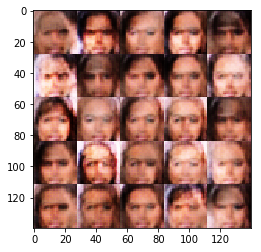

Epoch: 1, Batch: 1050, Disc. Loss: 1.340233, Gen. Loss: 0.819033
Epoch: 1, Batch: 1100, Disc. Loss: 1.449397, Gen. Loss: 0.698062
Epoch: 1, Batch: 1150, Disc. Loss: 1.386522, Gen. Loss: 0.740817
Epoch: 1, Batch: 1200, Disc. Loss: 1.284470, Gen. Loss: 0.836932
Epoch: 1, Batch: 1250, Disc. Loss: 1.378858, Gen. Loss: 0.726238
Epoch: 1, Batch: 1300, Disc. Loss: 1.341913, Gen. Loss: 0.702864
Epoch: 1, Batch: 1350, Disc. Loss: 1.345024, Gen. Loss: 0.667603
Epoch: 1, Batch: 1400, Disc. Loss: 1.238281, Gen. Loss: 0.707810
Epoch: 1, Batch: 1450, Disc. Loss: 1.500746, Gen. Loss: 0.775317
Epoch: 1, Batch: 1500, Disc. Loss: 1.178858, Gen. Loss: 0.709194


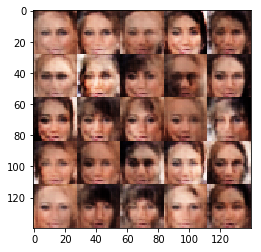

Epoch: 1, Batch: 1550, Disc. Loss: 1.180611, Gen. Loss: 0.753129
Epoch: 1, Batch: 1600, Disc. Loss: 1.217495, Gen. Loss: 0.756580
Epoch: 1, Batch: 1650, Disc. Loss: 1.265114, Gen. Loss: 0.740428
Epoch: 1, Batch: 1700, Disc. Loss: 1.266968, Gen. Loss: 0.776502
Epoch: 1, Batch: 1750, Disc. Loss: 1.362423, Gen. Loss: 0.670009
Epoch: 1, Batch: 1800, Disc. Loss: 1.221623, Gen. Loss: 0.763817
Epoch: 1, Batch: 1850, Disc. Loss: 1.484626, Gen. Loss: 0.866874
Epoch: 1, Batch: 1900, Disc. Loss: 1.230506, Gen. Loss: 0.866710
Epoch: 1, Batch: 1950, Disc. Loss: 1.331836, Gen. Loss: 0.668256
Epoch: 1, Batch: 2000, Disc. Loss: 1.358156, Gen. Loss: 1.032623


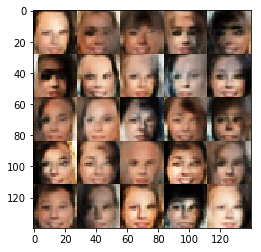

Epoch: 1, Batch: 2050, Disc. Loss: 1.382545, Gen. Loss: 0.592545
Epoch: 1, Batch: 2100, Disc. Loss: 1.279886, Gen. Loss: 0.840107
Epoch: 1, Batch: 2150, Disc. Loss: 1.220864, Gen. Loss: 0.800118
Epoch: 1, Batch: 2200, Disc. Loss: 1.224331, Gen. Loss: 0.692191
Epoch: 1, Batch: 2250, Disc. Loss: 1.363666, Gen. Loss: 0.860933
Epoch: 1, Batch: 2300, Disc. Loss: 1.358497, Gen. Loss: 0.904615
Epoch: 1, Batch: 2350, Disc. Loss: 1.278330, Gen. Loss: 0.810752
Epoch: 1, Batch: 2400, Disc. Loss: 1.258595, Gen. Loss: 0.712877
Epoch: 1, Batch: 2450, Disc. Loss: 1.376270, Gen. Loss: 0.645761
Epoch: 1, Batch: 2500, Disc. Loss: 1.210714, Gen. Loss: 0.683606


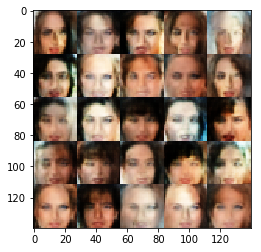

Epoch: 1, Batch: 2550, Disc. Loss: 1.391483, Gen. Loss: 0.821618
Epoch: 1, Batch: 2600, Disc. Loss: 1.278931, Gen. Loss: 0.986311
Epoch: 1, Batch: 2650, Disc. Loss: 1.041027, Gen. Loss: 0.910498
Epoch: 1, Batch: 2700, Disc. Loss: 1.169568, Gen. Loss: 0.764983
Epoch: 1, Batch: 2750, Disc. Loss: 1.233440, Gen. Loss: 0.679749
Epoch: 1, Batch: 2800, Disc. Loss: 1.260211, Gen. Loss: 0.774471
Epoch: 1, Batch: 2850, Disc. Loss: 1.439178, Gen. Loss: 1.229251
Epoch: 1, Batch: 2900, Disc. Loss: 1.072167, Gen. Loss: 1.191844
Epoch: 1, Batch: 2950, Disc. Loss: 1.116297, Gen. Loss: 0.828682
Epoch: 1, Batch: 3000, Disc. Loss: 1.103387, Gen. Loss: 0.969462


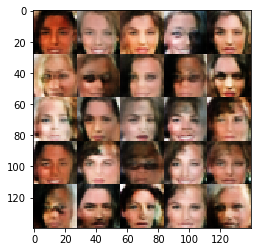

Epoch: 1, Batch: 3050, Disc. Loss: 1.296382, Gen. Loss: 0.823539
Epoch: 1, Batch: 3100, Disc. Loss: 1.245420, Gen. Loss: 0.895176
Epoch: 1, Batch: 3150, Disc. Loss: 1.185646, Gen. Loss: 0.674511
Epoch: 1, Batch: 3200, Disc. Loss: 1.316667, Gen. Loss: 0.607207
Epoch: 1, Batch: 3250, Disc. Loss: 1.110573, Gen. Loss: 0.910261
Epoch: 1, Batch: 3300, Disc. Loss: 1.158223, Gen. Loss: 1.074459
Epoch: 1, Batch: 3350, Disc. Loss: 1.139594, Gen. Loss: 1.074760
Epoch: 1, Batch: 3400, Disc. Loss: 1.341983, Gen. Loss: 0.617743
Epoch: 1, Batch: 3450, Disc. Loss: 1.344759, Gen. Loss: 0.685323
Epoch: 1, Batch: 3500, Disc. Loss: 1.113276, Gen. Loss: 0.991691


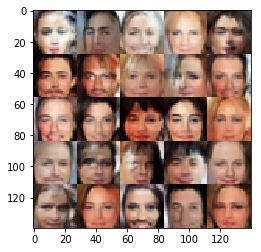

Epoch: 1, Batch: 3550, Disc. Loss: 1.283769, Gen. Loss: 0.550033
Epoch: 1, Batch: 3600, Disc. Loss: 1.154562, Gen. Loss: 0.864669
Epoch: 1, Batch: 3650, Disc. Loss: 1.112278, Gen. Loss: 1.016739
Epoch: 1, Batch: 3700, Disc. Loss: 1.043740, Gen. Loss: 0.991880
Epoch: 1, Batch: 3750, Disc. Loss: 1.012687, Gen. Loss: 0.903647
Epoch: 1, Batch: 3800, Disc. Loss: 1.007392, Gen. Loss: 0.879180
Epoch: 1, Batch: 3850, Disc. Loss: 0.962213, Gen. Loss: 0.764097
Epoch: 1, Batch: 3900, Disc. Loss: 1.093806, Gen. Loss: 0.731389
Epoch: 1, Batch: 3950, Disc. Loss: 1.076503, Gen. Loss: 0.911607
Epoch: 1, Batch: 4000, Disc. Loss: 1.106408, Gen. Loss: 0.854425


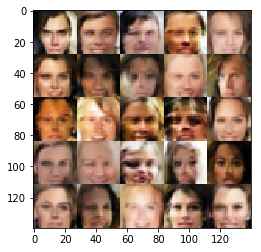

Epoch: 1, Batch: 4050, Disc. Loss: 1.181264, Gen. Loss: 0.650669
Epoch: 1, Batch: 4100, Disc. Loss: 1.128418, Gen. Loss: 0.694013
Epoch: 1, Batch: 4150, Disc. Loss: 1.119990, Gen. Loss: 1.119082
Epoch: 1, Batch: 4200, Disc. Loss: 0.931585, Gen. Loss: 1.147115
Epoch: 1, Batch: 4250, Disc. Loss: 1.113659, Gen. Loss: 0.584320
Epoch: 1, Batch: 4300, Disc. Loss: 1.020905, Gen. Loss: 1.023125
Epoch: 1, Batch: 4350, Disc. Loss: 1.108457, Gen. Loss: 0.927975
Epoch: 1, Batch: 4400, Disc. Loss: 1.164761, Gen. Loss: 1.306973
Epoch: 1, Batch: 4450, Disc. Loss: 0.960078, Gen. Loss: 1.143751
Epoch: 1, Batch: 4500, Disc. Loss: 1.175572, Gen. Loss: 0.841642


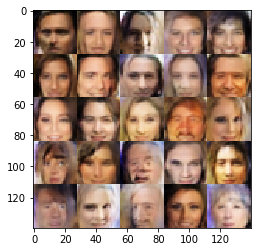

Epoch: 1, Batch: 4550, Disc. Loss: 1.263165, Gen. Loss: 0.850353
Epoch: 1, Batch: 4600, Disc. Loss: 1.124573, Gen. Loss: 1.536717
Epoch: 1, Batch: 4650, Disc. Loss: 1.043523, Gen. Loss: 0.942205
Epoch: 1, Batch: 4700, Disc. Loss: 0.869031, Gen. Loss: 1.164695
Epoch: 1, Batch: 4750, Disc. Loss: 1.081056, Gen. Loss: 0.871732
Epoch: 1, Batch: 4800, Disc. Loss: 1.041574, Gen. Loss: 0.832329
Epoch: 1, Batch: 4850, Disc. Loss: 1.366002, Gen. Loss: 0.614956
Epoch: 1, Batch: 4900, Disc. Loss: 0.966496, Gen. Loss: 1.044550
Epoch: 1, Batch: 4950, Disc. Loss: 0.967212, Gen. Loss: 0.719096
Epoch: 1, Batch: 5000, Disc. Loss: 1.138501, Gen. Loss: 0.788484


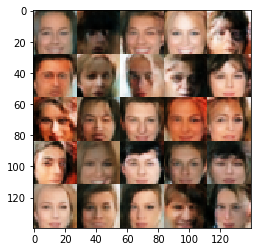

Epoch: 1, Batch: 5050, Disc. Loss: 1.176074, Gen. Loss: 0.734034
Epoch: 1, Batch: 5100, Disc. Loss: 1.092777, Gen. Loss: 0.992379
Epoch: 1, Batch: 5150, Disc. Loss: 1.012813, Gen. Loss: 0.828655
Epoch: 1, Batch: 5200, Disc. Loss: 0.971007, Gen. Loss: 1.041462
Epoch: 1, Batch: 5250, Disc. Loss: 1.299789, Gen. Loss: 1.738313
Epoch: 1, Batch: 5300, Disc. Loss: 1.051978, Gen. Loss: 0.806546
Epoch: 1, Batch: 5350, Disc. Loss: 1.239782, Gen. Loss: 1.461813
Epoch: 1, Batch: 5400, Disc. Loss: 1.023401, Gen. Loss: 1.158638
Epoch: 1, Batch: 5450, Disc. Loss: 0.907208, Gen. Loss: 1.102573
Epoch: 1, Batch: 5500, Disc. Loss: 0.899434, Gen. Loss: 0.836880


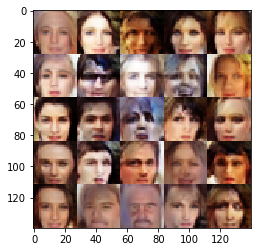

Epoch: 1, Batch: 5550, Disc. Loss: 0.976643, Gen. Loss: 1.660981
Epoch: 1, Batch: 5600, Disc. Loss: 0.727049, Gen. Loss: 1.174106
Epoch: 1, Batch: 5650, Disc. Loss: 1.019818, Gen. Loss: 1.306102
Epoch: 1, Batch: 5700, Disc. Loss: 0.975231, Gen. Loss: 1.346524
Epoch: 1, Batch: 5750, Disc. Loss: 0.921236, Gen. Loss: 1.320418
Epoch: 1, Batch: 5800, Disc. Loss: 0.951840, Gen. Loss: 0.994641
Epoch: 1, Batch: 5850, Disc. Loss: 0.940562, Gen. Loss: 1.406967
Epoch: 1, Batch: 5900, Disc. Loss: 0.890556, Gen. Loss: 0.836074
Epoch: 1, Batch: 5950, Disc. Loss: 0.973249, Gen. Loss: 0.961364
Epoch: 1, Batch: 6000, Disc. Loss: 1.000551, Gen. Loss: 0.879716


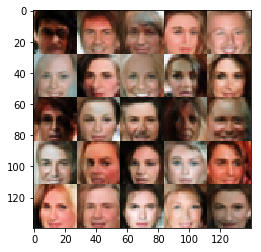

Epoch: 1, Batch: 6050, Disc. Loss: 0.933550, Gen. Loss: 0.783649
Epoch: 1, Batch: 6100, Disc. Loss: 1.161351, Gen. Loss: 0.730484
Epoch: 1, Batch: 6150, Disc. Loss: 0.936967, Gen. Loss: 0.890692
Epoch: 1, Batch: 6200, Disc. Loss: 1.026742, Gen. Loss: 1.795719
Epoch: 1, Batch: 6250, Disc. Loss: 0.857233, Gen. Loss: 1.272919
Epoch: 1, Batch: 6300, Disc. Loss: 1.022894, Gen. Loss: 0.988188


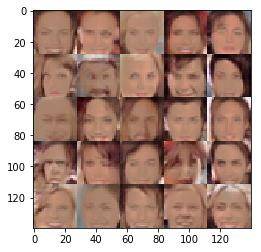

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    celeb_sess = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches, celeba_dataset.shape, 
                       celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.